[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/elcursodeia-code/blob/master/ml/03_clasificacion.ipynb)

## Dataset MNIST

In [5]:
from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

In [6]:
X, y = mnist["data"].values, mnist["target"].values
X.shape, y.shape

((70000, 784), (70000,))

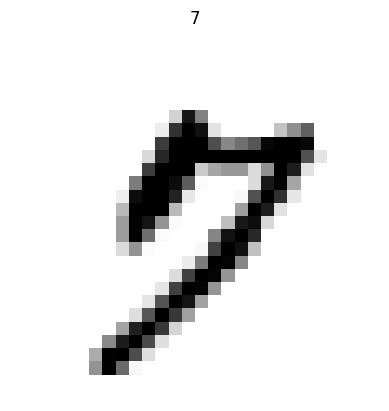

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

ix = random.randint(0, len(X)-1)
some_digit = X[ix]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.title(y[ix])
plt.show()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Clasificación binaria

In [9]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

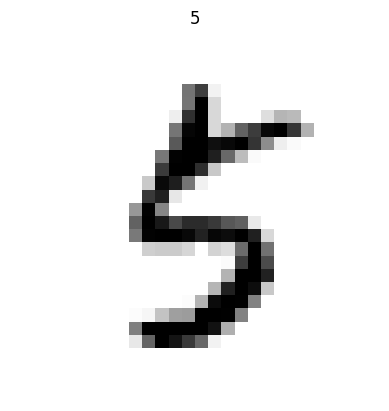

array([ True])

In [11]:
ix = random.randint(0, len(X)-1)
some_digit = X[ix]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.title(y[ix])
plt.show()
sgd_clf.predict([some_digit])

## Métricas de clasificación


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Es este un buen resultado?

In [13]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

$$ acc = \frac{TP + TN}{TP + TN + FP + FN} $$


Matriz de confusión

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

<Axes: >

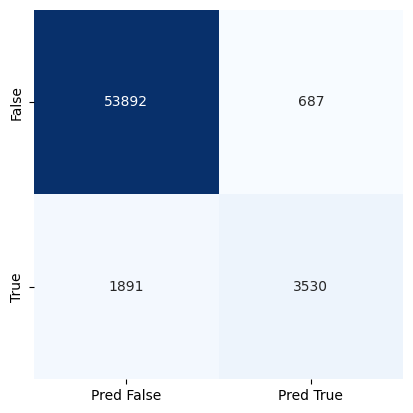

In [17]:
import seaborn as sns
import pandas as pd

# Convert confusion matrix to DataFrame for better visualization
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_df = pd.DataFrame(conf_matrix, index=['False', 'True'], columns=['Pred False', 'Pred True'])

# Create a heatmap
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)

Recision vs Recall

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

np.float64(0.8370879772350012)

$$ precision = \frac{TP}{TP + FP} $$


In [19]:
TP = 3530
FP = 687
TP / (TP + FP)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

$$ recall = \frac{TP}{TP + FN} $$

In [21]:
FN = 1891
TP / (TP + FN)

0.6511713705958311

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

\begin{equation}
  F_1 = 2 \times \frac{precision \times recall}{precision + recall}
\end{equation}

Tradeoff

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3110.12790618])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

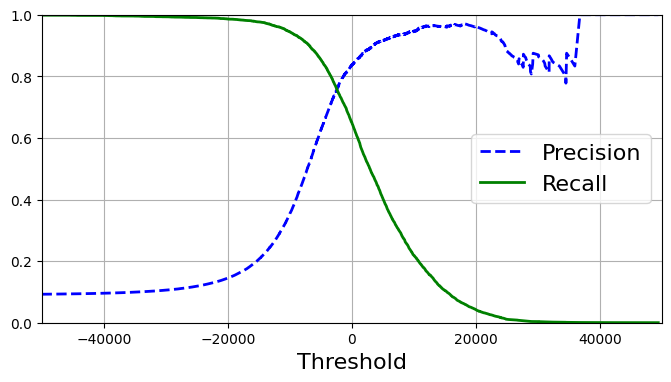

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)               
plt.show()

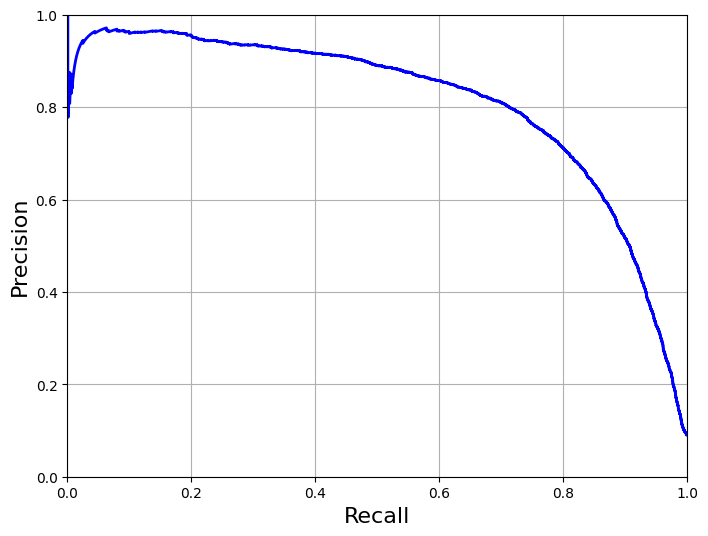

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [31]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

Curva ROC

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

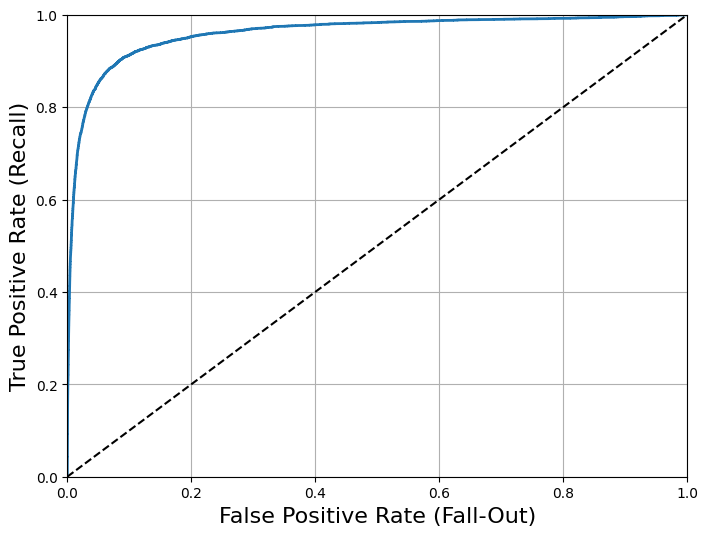

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)              
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

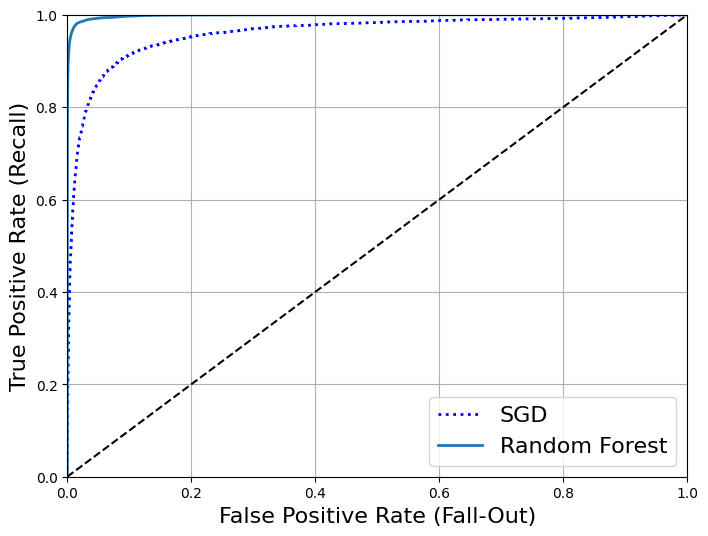

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983296721818179)

In [39]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

precision_score(y_train_5, y_train_pred_forest)

np.float64(0.9898819561551433)

In [40]:
recall_score(y_train_5, y_train_pred_forest)

np.float64(0.8662608374838591)

## Clasificación multiclase

In [41]:
from sklearn.svm import SVC # OvO

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array(['7'], dtype=object)

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.93672053,  8.19324105,  4.98585718,  1.87180719,  7.1107916 ,
         0.85998001,  2.88509577,  9.19744483, -0.18355263,  6.01561605]])

In [43]:
np.argmax(some_digit_scores)

np.int64(7)

In [44]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [45]:
from sklearn.multiclass import OneVsRestClassifier # OvR

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array(['7'], dtype='<U1')

In [46]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [47]:
sgd_clf.decision_function([some_digit])

array([[-17597.93674022, -18767.81478676,  -7196.14045038,
         -1494.72206941, -13137.45473728,  -2267.5427179 ,
        -13477.77931711, -12328.37353678,  -2598.37719045,
         -2537.24282435]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Análisis de errores

In [50]:
# OJO: puede tardar mucho tiempo

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:3000], y_train[:3000], cv=3)
conf_mx = confusion_matrix(y_train[:3000], y_train_pred[:3000])

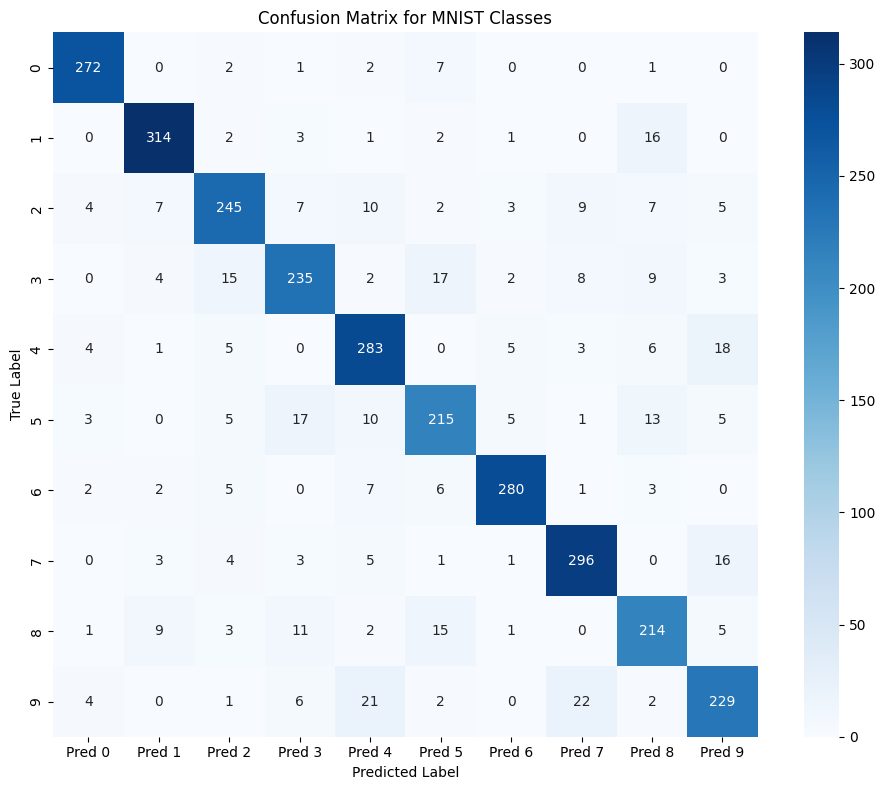

In [56]:
# Create a DataFrame from the confusion matrix
conf_df = pd.DataFrame(conf_mx, 
                       index=[str(i) for i in range(10)], 
                       columns=[f'Pred {i}' for i in range(10)])

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.title('Confusion Matrix for MNIST Classes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [58]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

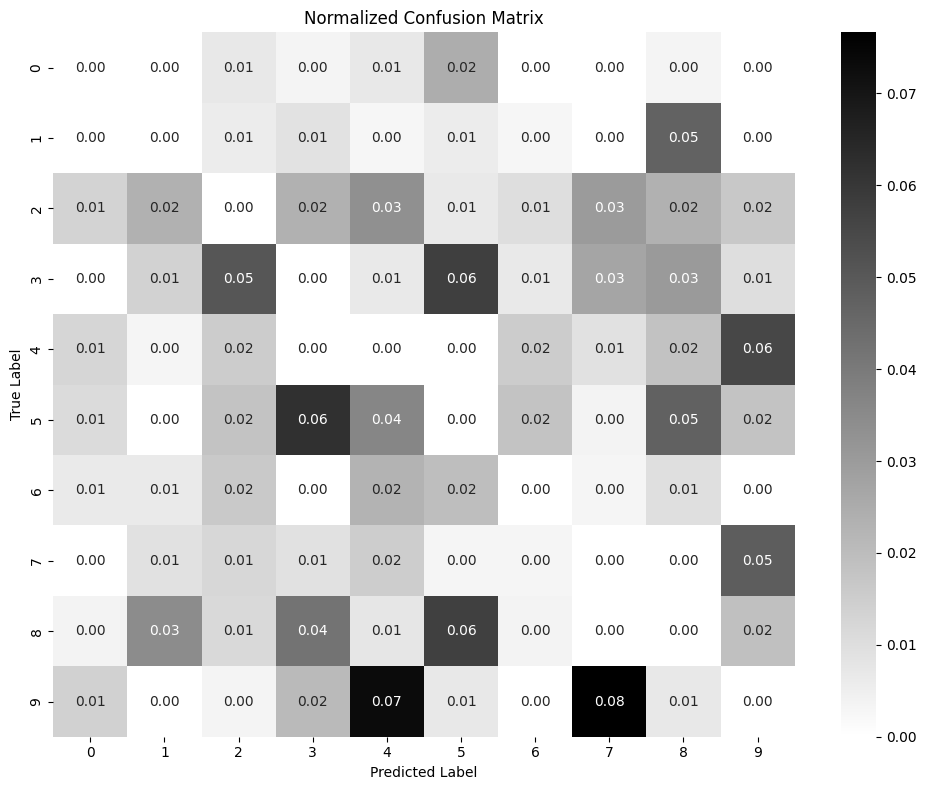

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(10, 8))
sns.heatmap(norm_conf_mx, cmap='gray_r', annot=True, fmt='.2f', cbar=True)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Clasificación multietiqueta

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train.astype(int) >= 7)
y_train_odd = (y_train.astype(int) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [69]:
# OJO: puede tardar mucho tiempo

y_train_knn_pred = cross_val_predict(knn_clf, X_train[:100], y_multilabel[:100], cv=3)
f1_score(y_multilabel[:100], y_train_knn_pred[:100], average="macro")

np.float64(0.8181818181818181)

## Clasificación multisalida

In [70]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

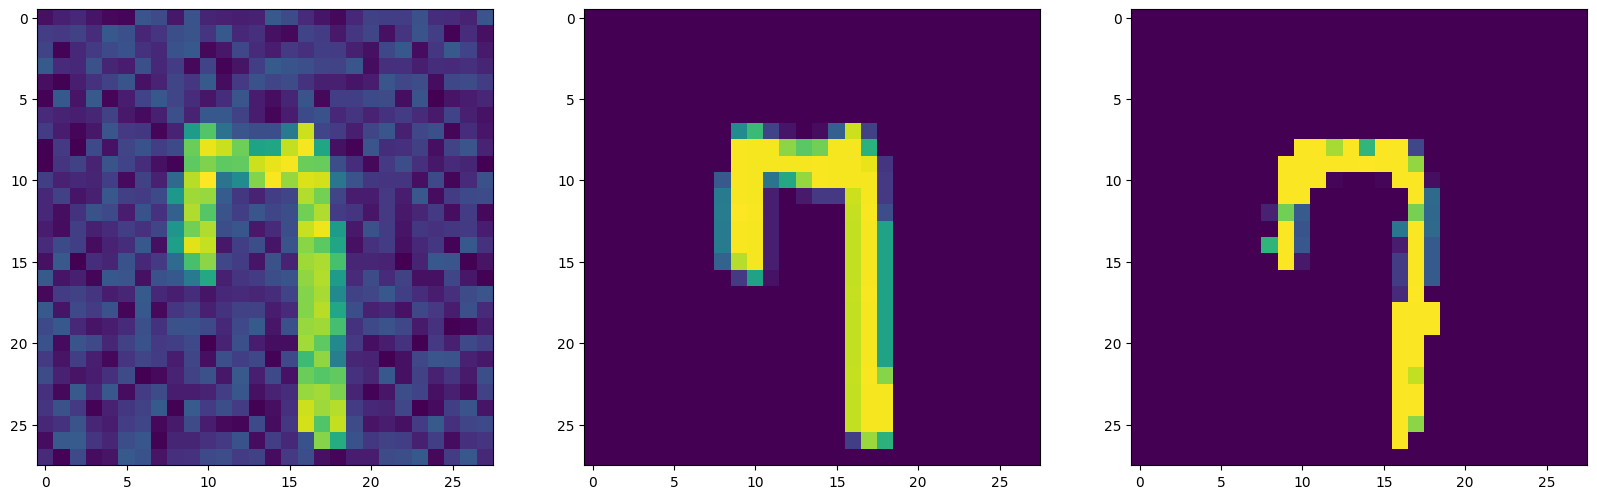

In [72]:
some_index = 80
plt.figure(figsize=(20,10))
plt.subplot(131); plt.imshow(X_test_mod[some_index].reshape(28,28))
plt.subplot(132); plt.imshow(y_test_mod[some_index].reshape(28,28))
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plt.subplot(133); plt.imshow(clean_digit.reshape(28,28))
plt.show()